# 语义分割和数据集

在前几节讨论的目标检测问题中，我们一直使用方形边界框来标注和预测图像中的目标。本节将探讨语义分割（semantic segmentation）问题，它关注如何将图像分割成属于不同语义类别的区域。值得一提的是，这些语义区域的标注和预测都是像素级的。图 9.10 展示了语义分割中图像有关狗、猫和背景的标签。可以看到，跟目标检测相比，语义分割标注的像素级的边框显然更加精细。

![语义分割中图像有关狗、猫和背景的标签。](../img/segmentation.svg)


## 图像分割和实例分割

计算机视觉领域还有两个和语义分割相似的重要问题：图像分割（image segmentation）和实例分割（instance segmentation）。我们在这里将它们和语义分割简单区分一下：

* 图像分割将图像分割成若干组成区域。这类问题的方法通常利用图像中像素之间的相关性。它在训练时无需有关图像像素的标签信息，在预测时也无法保证分割出的区域具有我们希望得到的语义。以图 9.10 的图像为输入，图像分割可能将狗分割成两个区域：一个覆盖以黑色为主的嘴巴和眼睛，而另一个覆盖以黄色为主的其余部分身体。
* 实例分割又叫检测并分割（simultaneous detection and segmentation）。它研究如何识别图像中各个目标实例的像素级区域。与语义分割有所不同，实例分割不仅需要区分语义，还要区分不同的目标实例。如果图像中有两只狗，实例分割需要区分像素属于这两只狗中的哪一只。


## Pascal VOC2012 语义分割数据集

语义分割的一个重要数据集叫做 Pascal VOC2012 [1]。为了更好地了解这个数据集，我们先导入实验所需的包或模块。

In [1]:
%matplotlib inline
import gluonbook as gb
from mxnet import gluon, image, nd
from mxnet.gluon import data as gdata, utils as gutils
import os
import sys
import tarfile

我们下载这个数据集的压缩包到`../data`路径下。压缩包大小是 2GB，下载需要一定时间。解压之后的数据集将会放置在`../data/VOCdevkit/VOC2012`路径下。

In [2]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def download_voc_pascal(data_dir='../data'):
    voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
    url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
           '/VOCtrainval_11-May-2012.tar')
    sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
    fname = gutils.download(url, data_dir, sha1_hash=sha1)
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_dir)
    return voc_dir

voc_dir = download_voc_pascal()

进入`../data/VOCdevkit/VOC2012`路径后，我们可以获取数据集的不同组成部分。其中`ImageSets/Segmentation`路径包含了指定训练和测试样本的文本文件，而`JPEGImages`和`SegmentationClass`路径下分别包含了样本的输入图像和标签。这里的标签也是图像格式，其尺寸和它所标注的输入图像的尺寸相同。标签中颜色相同的像素属于同一个语义类别。下面定义`read_voc_images`函数将输入图像和标签全部读进内存。

In [3]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def read_voc_images(root=voc_dir, is_train=True):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = image.imread('%s/JPEGImages/%s.jpg' % (root, fname))
        labels[i] = image.imread(
            '%s/SegmentationClass/%s.png' % (root, fname))
    return features, labels

train_features, train_labels = read_voc_images()

我们画出前五张输入图像和它们的标签。在标签图像中，白色和黑色分别代表边框和背景，而其他不同的颜色则对应不同的类别。

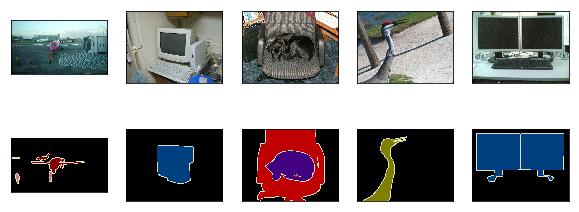

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
gb.show_images(imgs, 2, n);

接下来，我们列出标签中每个 RGB 颜色的值及其标注的类别。

In [5]:
# 该常量已保存在 gluonbook 包中方便以后使用。
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# 该常量已保存在 gluonbook 包中方便以后使用。
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

有了上面定义的两个常量以后，我们可以很容易地查找标签中每个像素的类别索引。

In [6]:
colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 本函数已保存在 gluonbook 包中方便以后使用。
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

例如，第一张样本图像中飞机头部区域的类别索引为 1，而背景全是 0。

In [7]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 <NDArray 10x10 @cpu(0)>, 'aeroplane')

### 预处理数据

在之前的章节中，我们通过缩放图像使其符合模型的输入形状。然而在语义分割里，这样做会需要将预测的像素类别重新映射回原始尺寸的输入图像。这样的映射难以做到精确，尤其在不同语义的分割区域。为了避免这个问题，我们将图像裁剪成固定尺寸而不是缩放。具体来说，我们使用图像增广里的随机裁剪，并对输入图像和标签裁剪相同区域。

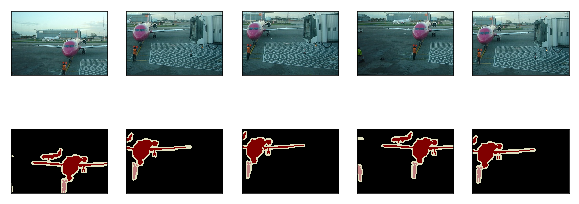

In [8]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def voc_rand_crop(feature, label, height, width):
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
gb.show_images(imgs[::2] + imgs[1::2], 2, n);

### 自定义语义分割数据集类

我们通过继承 Gluon 提供的`Dataset`类自定义了一个语义分割数据集类`VOCSegDataset`。通过实现`__getitem__`函数，我们可以任意访问数据集中索引为`idx`的输入图像及其每个像素的类别索引。由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本需要通过自定义的`filter`函数所移除。此外，我们还定义了`normalize_image`函数，从而对输入图像的 RGB 三个通道的值分别做标准化。

In [9]:
# 本类已保存在 gluonbook 包中方便以后使用。
class VOCSegDataset(gdata.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label):
        self.rgb_mean = nd.array([0.485, 0.456, 0.406])
        self.rgb_std = nd.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose((2, 0, 1)),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### 读取数据集

我们通过自定义的`VOCSegDataset`类来分别创建训练集和测试集的实例。假设我们指定随机裁剪的输出图像的形状为 $320\times 480$。下面我们可以查看训练集和测试集所保留的样本个数。

In [10]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label)

read 1114 examples


read 1078 examples


设批量大小为 64，分别定义训练集和测试集的迭代器。

In [11]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(voc_train, batch_size, shuffle=True,
                              last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(voc_test, batch_size, last_batch='discard',
                             num_workers=num_workers)

打印第一个小批量的形状。不同于图像分类和目标识别，这里的标签是一个三维的数组。

In [12]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


## 小结

* 语义分割关注如何将图像分割成属于不同语义类别的区域。
* 语义分割的一个重要数据集叫做 Pascal VOC2012。
* 由于语义分割的输入图像和标签在像素上一一对应，我们将图像随机裁剪成固定尺寸而不是缩放。

## 练习

* 回忆[“图像增广”](image-augmentation.md)一节中的内容。哪些在图像分类中使用的图像增广方法难以用于语义分割？

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/7218)

![](../img/qr_semantic-segmentation-and-dataset.svg)

##  参考文献

[1] Pascal VOC2012 数据集。http://host.robots.ox.ac.uk/pascal/VOC/voc2012/